# Implement Estimator



#### 1. Determine the standard deviation of the measurement noise of both GPS X data and Accelerometer X data

To determine the standard deviation, I used LibreOffice Calc, copied the data and used STDEV() to get the results.

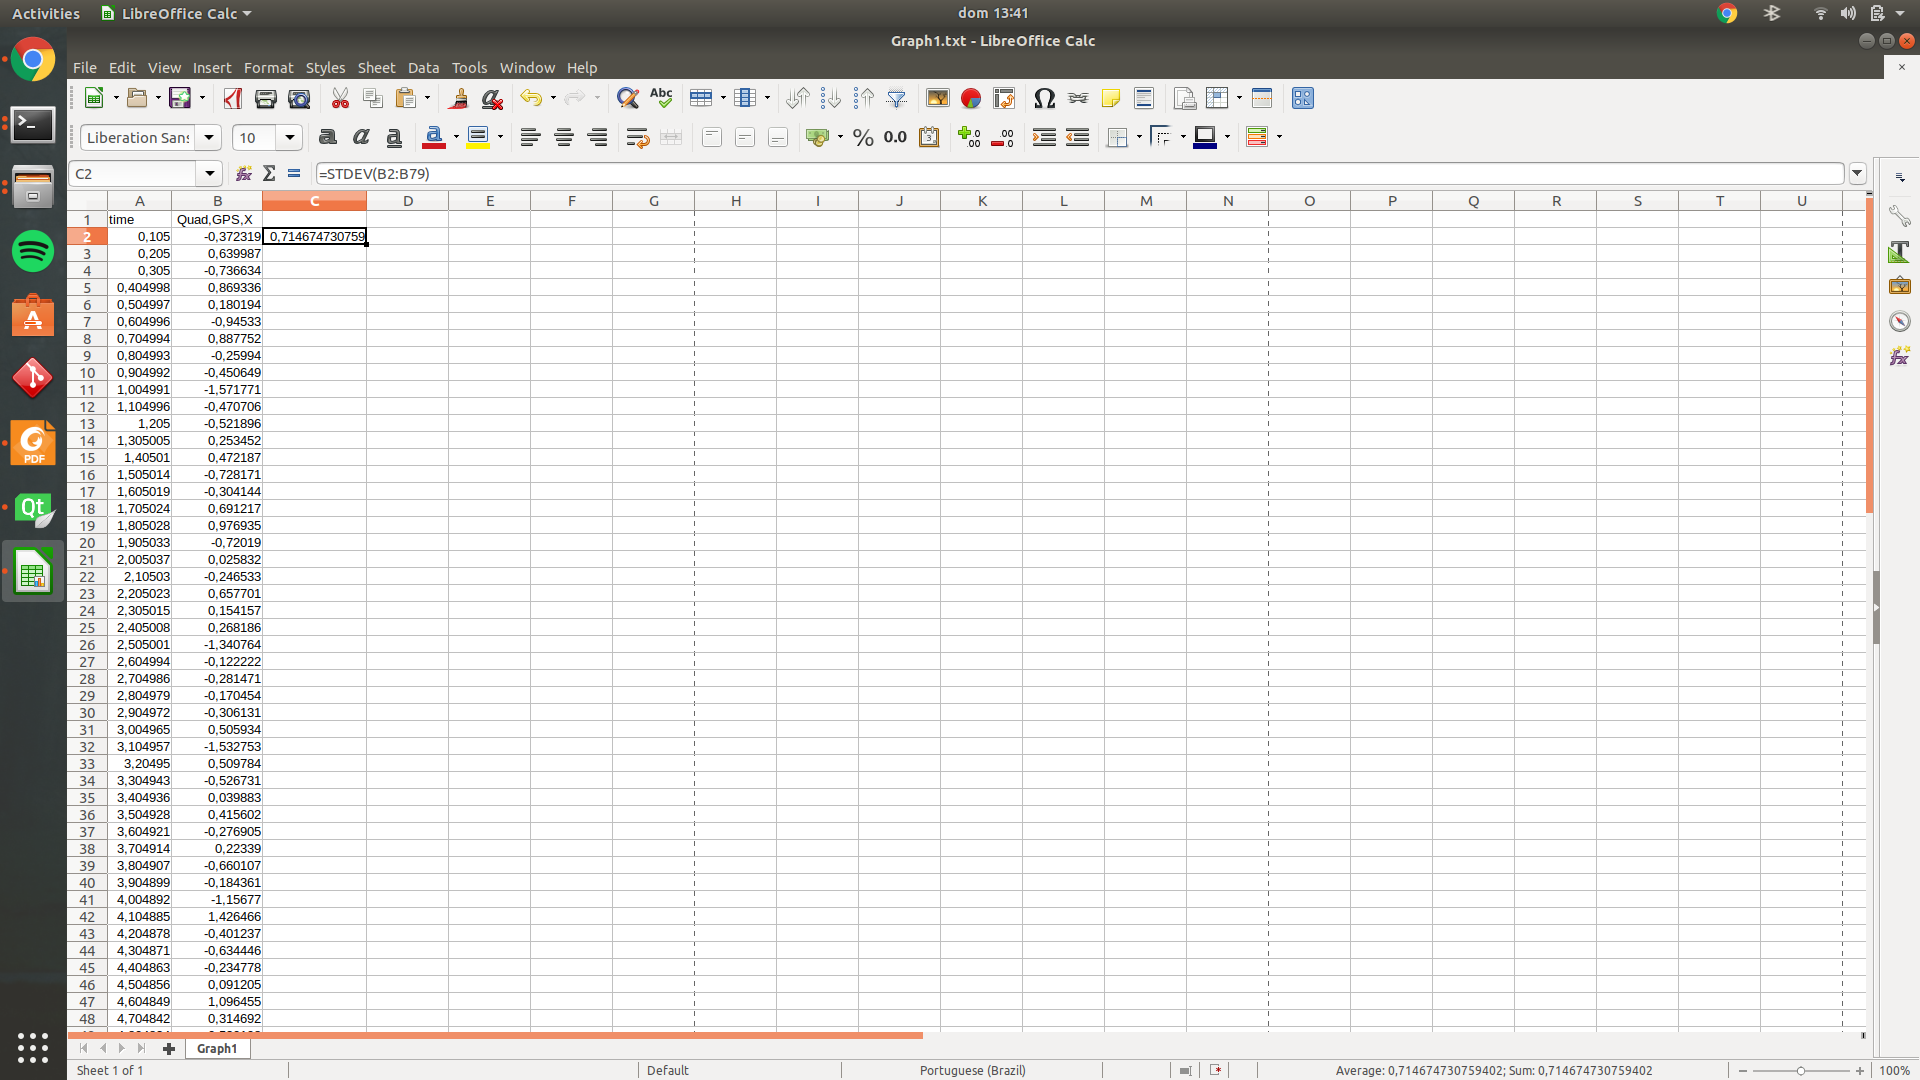



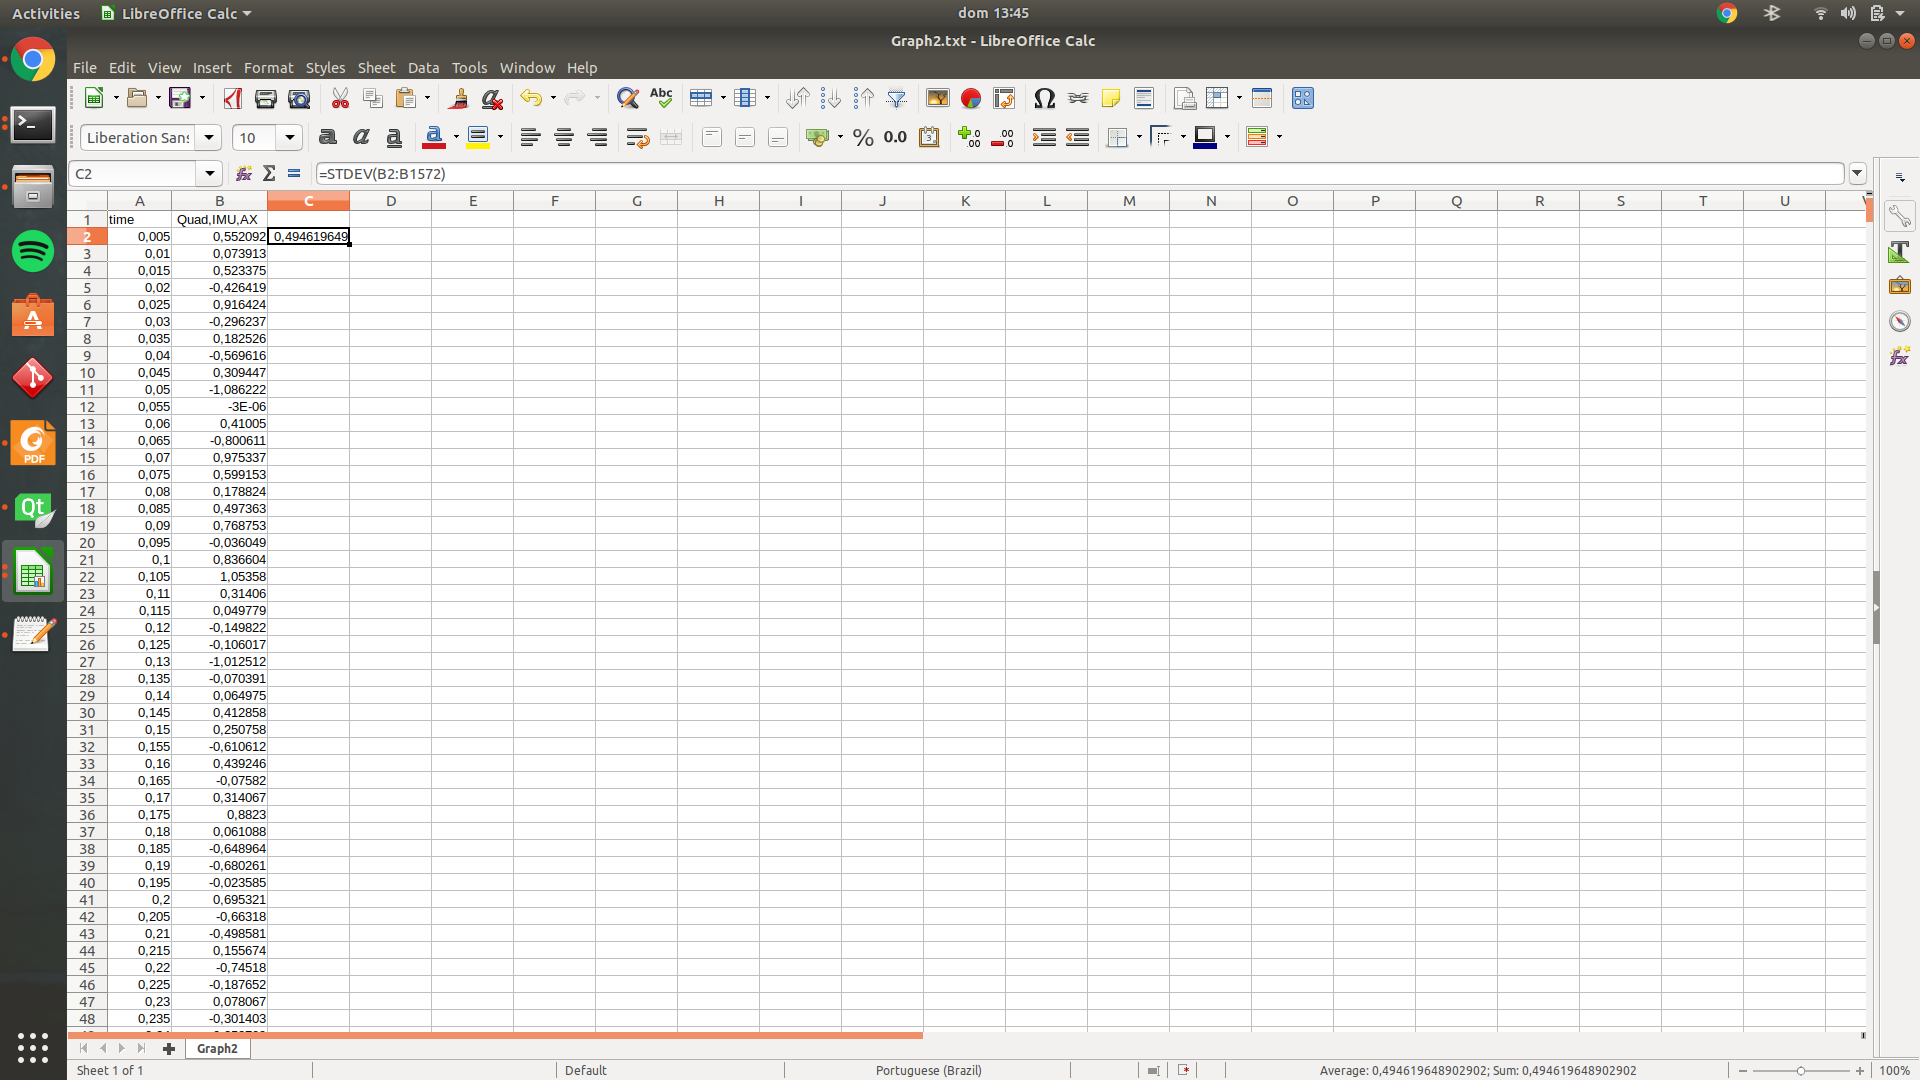

#### 2. Implement a better rate gyro attitude integration scheme in the UpdateFromIMU() function.

To implement a better rate gyro, I followed the NonLinear Complementary Filter implementation from Estimation for Quadrotors 7.1.2.
The implemented function is shown above.

```
void QuadEstimatorEKF::UpdateFromIMU(V3F accel, V3F gyro)
{
  // Complementary filter-type attitude filter

  Quaternion<float> q_t = Quaternion<float>::FromEuler123_RPY(rollEst, pitchEst, ekfState(6));
  Quaternion<float> dq = Quaternion<float>::FromEuler123_RPY(dtIMU * gyro.x, dtIMU * gyro.y, dtIMU * gyro.z);
  Quaternion<float> q_t_est = dq * q_t;

  float predictedPitch = q_t_est.Pitch();
  float predictedRoll = q_t_est.Roll();
  ekfState(6) = q_t_est.Yaw();	// yaw

  if (ekfState(6) > F_PI) ekfState(6) -= 2.f*F_PI;
  if (ekfState(6) < -F_PI) ekfState(6) += 2.f*F_PI;

  // CALCULATE UPDATE
  accelRoll = atan2f(accel.y, accel.z);
  accelPitch = atan2f(-accel.x, 9.81f);

  // FUSE INTEGRATION AND UPDATE
  rollEst = attitudeTau / (attitudeTau + dtIMU) * (predictedRoll)+dtIMU / (attitudeTau + dtIMU) * accelRoll;
  pitchEst = attitudeTau / (attitudeTau + dtIMU) * (predictedPitch)+dtIMU / (attitudeTau + dtIMU) * accelPitch;

  lastGyro = gyro;
}```

#### 3. Implement all of the elements of the prediction step for the estimator.








To generate the Predict step, first the PredictState() function was implemented. Here we calculate the g function based on Estimation for Quadrotors equation (49).

```
VectorXf QuadEstimatorEKF::PredictState(VectorXf curState, float dt, V3F accel, V3F gyro)
{
  assert(curState.size() == QUAD_EKF_NUM_STATES);
  VectorXf predictedState = curState;
  // Predict the current state forward by time dt using current accelerations and body rates as input
  // INPUTS: 
  //   curState: starting state
  //   dt: time step to predict forward by [s]
  //   accel: acceleration of the vehicle, in body frame, *not including gravity* [m/s2]
  //   gyro: body rates of the vehicle, in body frame [rad/s]
  //   
  // OUTPUT:
  //   return the predicted state as a vector

  Quaternion<float> attitude = Quaternion<float>::FromEuler123_RPY(rollEst, pitchEst, curState(6));

  predictedState(0) = curState(0) + curState(3) * dt;
  predictedState(1) = curState(1) + curState(4) * dt;
  predictedState(2) = curState(2) + curState(5) * dt;

  V3F accel_gf = attitude.Rotate_BtoI(accel);

  predictedState(3) = curState(3) + accel_gf.x * dt;
  predictedState(4) = curState(4) + accel_gf.y * dt;
  predictedState(5) = curState(5) + (accel_gf.z - 9.81f) * dt;
  predictedState(6) = curState(6);


  return predictedState;
}```

Next, the GetRbgPrime was implemented, following Estimation for Quadrotors equation (52).
```

MatrixXf QuadEstimatorEKF::GetRbgPrime(float roll, float pitch, float yaw)
{
  // first, figure out the Rbg_prime
  MatrixXf RbgPrime(3, 3);
  RbgPrime.setZero();

  // Return the partial derivative of the Rbg rotation matrix with respect to yaw. We call this RbgPrime.
  // INPUTS: 
  //   roll, pitch, yaw: Euler angles at which to calculate RbgPrime
  //   
  // OUTPUT:
  //   return the 3x3 matrix representing the partial derivative at the given point


  RbgPrime(0, 0) = -cos(pitch) * sin(yaw);
  RbgPrime(0, 1) = -sin(roll) * sin(pitch) * sin(yaw) - cos(roll) * cos(yaw);
  RbgPrime(0, 2) = -cos(roll) * sin(pitch) * sin(yaw) + sin(roll) * cos(yaw);
  RbgPrime(1, 0) = cos(pitch) * cos(yaw);
  RbgPrime(1, 1) = sin(roll) * sin(pitch) * cos(yaw) - cos(roll) * sin(yaw);
  RbgPrime(1, 2) = cos(roll) * sin(pitch) * cos(yaw) + sin(roll) * sin(yaw);
  RbgPrime(2, 0) = 0.0f;
  RbgPrime(2, 1) = 0.0f;
  RbgPrime(2, 2) = 0.0f;


  return RbgPrime;
}
```

Finally, to implement the Predict function, having GetRbgPrime, we just had to implement gPrime, following equation (51) and then calculate the Covariance (ekfCov) for the new predicted State.

```
void QuadEstimatorEKF::Predict(float dt, V3F accel, V3F gyro)
{
  // predict the state forward
  VectorXf newState = PredictState(ekfState, dt, accel, gyro);

  // Predict the current covariance forward by dt using the current accelerations and body rates as input.
  // INPUTS: 
  //   dt: time step to predict forward by [s]
  //   accel: acceleration of the vehicle, in body frame, *not including gravity* [m/s2]
  //   gyro: body rates of the vehicle, in body frame [rad/s]
  //   state (member variable): current state (state at the beginning of this prediction)
  //   
  // OUTPUT:
  //   update the member variable cov to the predicted covariance


  // we'll want the partial derivative of the Rbg matrix
  MatrixXf RbgPrime = GetRbgPrime(rollEst, pitchEst, ekfState(6));

  // we've created an empty Jacobian for you, currently simply set to identity
  MatrixXf gPrime(QUAD_EKF_NUM_STATES, QUAD_EKF_NUM_STATES);
  gPrime.setIdentity();

  MatrixXf accel_m(3, 1);
  accel_m << accel.x,
             accel.y,
             accel.z;

  MatrixXf mult = RbgPrime * accel_m * dt;

  gPrime(0,3) = dt;
  gPrime(1,4) = dt;
  gPrime(2,5) = dt;
  gPrime(3,6) = mult(0,0);
  gPrime(4,6) = mult(1,0);
  gPrime(5,6) = mult(2,0);

  ekfCov = gPrime * ekfCov * gPrime.transpose() + Q;

  ekfState = newState;
}
```

#### 4. Implement the magnetometer update.


To implement magnetometer update, we had to take into account the problem when we subtract two angles. Sometimes the subtraction will correspond to the long way around the circle. So to solve that, we have to take that case into consideration, just as it was done on the following code.

Basically, on the function, we have to update z (the measurement), zFromX (the current predicted state) and hPrime (the Jacobian of the measurement model), so these values can get passed to the Update() function, where the update algorithm is implemented.

```
void QuadEstimatorEKF::UpdateFromMag(float magYaw)
{
  VectorXf z(1), zFromX(1);
  z(0) = magYaw;

  MatrixXf hPrime(1, QUAD_EKF_NUM_STATES);
  hPrime.setZero();

  // MAGNETOMETER UPDATE

  hPrime(0,6) = 1.0f;
  zFromX(0) = ekfState(6);
  //Throws the estimated yaw close to the measurement
  if (z(0) - zFromX(0) > F_PI)
  {
    zFromX(0) += 2.f * F_PI;
  }
  else if (z(0) - zFromX(0) < -F_PI)
  {
    zFromX(0) -= 2.f * F_PI;
  }

  Update(z, hPrime, R_Mag, zFromX);
}```

#### 5. Implement the GPS update.


This is a simple function, where we just have to calculate z, hPrime and zFromX.
```
void QuadEstimatorEKF::UpdateFromGPS(V3F pos, V3F vel)
{
  VectorXf z(6), zFromX(6);
  z(0) = pos.x;
  z(1) = pos.y;
  z(2) = pos.z;
  z(3) = vel.x;
  z(4) = vel.y;
  z(5) = vel.z;

  MatrixXf hPrime(6, QUAD_EKF_NUM_STATES);
  hPrime.setZero();

  for(int i=0; i<6; i++){
      hPrime(i,i) = 1;
      zFromX(i) = ekfState(i);
  }

  Update(z, hPrime, R_GPS, zFromX);
}```

# Flight Evaluation


#### 1. Meet the performance criteria of each step.


After all the implementation described above, all the scenarios got a PASS.

#### 2. De-tune your controller to successfully fly the final desired box trajectory with your estimator and realistic sensors.


OLD VALUES:
```
# Position control gains
kpPosXY = 25
kpPosZ = 35
KiPosZ = 90

# Velocity control gains
kpVelXY = 10
kpVelZ = 17

# Angle control gains
kpBank = 20
kpYaw = 2

# Angle rate gains
kpPQR = 100, 100, 38
```
DE-TUNED VALUES:
```
# Position control gains
kpPosXY = 3
kpPosZ = 5
KiPosZ = 10

# Velocity control gains
kpVelXY = 5
kpVelZ = 10

# Angle control gains
kpBank = 10
kpYaw = 2

# Angle rate gains
kpPQR = 30, 30, 19
```